# Simulation der Ausbreitung von SARS-CoV-2 mit dem SEIR-Modell

Das SEIR-Modell verwendet ein System aus Differenzialgleichungen, um die Pandemie zu simulieren. Das Python-Modul SciPy enthält die Funktionen `odeint()` und `curve_fit()`, um das SEIR-Modell zu berechnen und einige ausgewählte Parameter so zu optimieren, damit sie zu den von der John-Hopkins-Universität gemeldeten Fallzahlen für Deutschland passen.

Die Simulation beginnt mit einigen Imports:

In [1]:
from IPython.display import display, Markdown, SVG
from equations import SEIR
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import datetime as dt
import numpy as np
import pandas as pd
import altair as alt
import requests
import os

Die Implementierung des Modells steht in der Klasse `SEIR` in [equations.py](https://github.com/pinae/SEIR-fit/blob/master/equations.py).

Aktuelle Zahlen der John-Hopkins-Universität liefert der folgende Webdienst praktischerweise bereits als JSON aufbereitet (die Ausgabe enthält die neuesten vier Zahlen):

In [2]:
germany_json = requests.get("https://corona.ersatzworld.net/data/Germany.json").json()
data = pd.DataFrame(np.stack([
        [dt.datetime.strptime(d, "%Y-%m-%d") for d in germany_json["dates"]], 
        germany_json["total"]
    ], axis=1), 
    columns=("Tag", "Fallzahl"))
data.tail(4)

Tag Fallzahl
79 2020-04-10   122171
80 2020-04-11   124908
81 2020-04-12   127854
82 2020-04-13   130072

Der nächste Schritt berechnet das `SEIR`-Modell und fittet vier Parameter, damit das Modell möglichst gut zu den Daten aus `data` passt. 

Die Simulation beginnt am 27.2.2020 (erste Zeile). Am 20.3.2020 und am 28.3.2020 wirkten sich Ausgangsbeschränkungen und eine Kontaktsperre auf die Zahlen aus, sodass das SEIR-Modell für die Zeiträume vor, zwischen und nach diesen Terminen unterschiedliche Werte für $R_{0}$ annimmt. Diese drei Werte sind die ersten drei  Parameter der Optimierung mit `curve_fit()`. Als vierten Parameter ermittelt die Optimierung auch den unbekannten Wert $E_{0}$, die zahl der infizierten aber noch nicht infektiösen Corona-Patienten am 27. Februar.

In [3]:
data = data[data["Tag"] >= dt.datetime(year=2020, month=2, day=27)].reset_index(drop=True)

it1 = dt.datetime(year=2020, month=3, day=20)
it2 = dt.datetime(year=2020, month=3, day=28)
it3 = dt.datetime(year=2020, month=4, day=20)
it4 = dt.datetime(year=2020, month=4, day=20)
cases = np.array(data["Fallzahl"])
bev_de = germany_json["population"]
times = np.arange(0., len(cases), 1.0)
model = SEIR(p0=(bev_de-data["Fallzahl"][0], 0, data["Fallzahl"][0], 0),
             intervention_times=[(it1-data["Tag"][0]).days, 
                                 (it2-data["Tag"][0]).days, 
                                 (data["Tag"][len(cases)-1]-data["Tag"][0]).days, 
                                 (data["Tag"][len(cases)-1]-data["Tag"][0]).days],
             t_vals=times)

params, _ = curve_fit(
    model, 
    xdata=times, 
    ydata=cases,
    p0=[3., 2., 1., 0.],
    bounds=(
        [0., 0., 0., 0.],
        [10., 10., 10., bev_de]
    ))
display(Markdown("Ergebnis der Optimierung mit `curve_fit()`:\n\n" +
    " 1. $R_{0}$ " + "ohne Einschränkungen: {0:.3f}".format(params[0]) + "\n\n" +
    " 2. $R_{0}$ " + "mit Ausgangsbeschränkungen: {0:.3f}".format(params[1]) + "\n\n" +
    " 3. $R_{0}$ " + "mit Kontaktsperre: {0:.3f}".format(params[2]) + "\n\n" +
    " 4. $E_{0}$" + ": {0:.1f}".format(params[3])))

Ergebnis der Optimierung mit `curve_fit()`:

 1. $R_{0}$ ohne Einschränkungen: 3.702

 2. $R_{0}$ mit Ausgangsbeschränkungen: 2.384

 3. $R_{0}$ mit Kontaktsperre: 1.006

 4. $E_{0}$: 0.1

Mit diesen Parametern berechnet der folgende Code die Vorhersagen des Modells für 5 Tage in die Zukunft:

In [4]:
r0, r1, r2, e0 = params
prediction_days = 5
times = np.arange(0., len(cases)+prediction_days, 1.0)
seir_predictions = model.getSEIR(times, [r0, r1, r2, r2, r2], e0)
sum_predictions = np.sum(seir_predictions[:, 1:], axis=1)

Die Zahl der „Susceptible“, also der Menschen, die noch angesteckt werden könnten, bisher aber noch nicht infiziert sind, ist zu Beginn der Simulation sehr hoch (etwas weniger als die Bevölkerungszahl). Ein Diagramm, das 83 Millionen und 100.000 mit der gleichen y-Achse darstellt, würde die interessanten Fallzahlen nur sehr klein oberhalb der x-Achse anzeigen. Damit das nicht passiert, setzt die Funktion `clip_values()` hohe Werte auf `None`:

In [5]:
def clip_values(v, max_val=bev_de):
    return np.where(np.less_equal(v, max_val), v, None)

Als Vorbereitung für ein Diagramm, an dem man leicht erkennt, wie gut die Simulation zu den echten Daten passt, packen die Folgenden Zeilen die nötigen Datenreihen hintereinander in ein Pandas-`DataFrame`. Anhand der Spalte `"Typ"` vergibt Alatair im Diagramm später die Farben der einzelnen Kurven.

In [6]:
dates = [data["Tag"][0] + dt.timedelta(days=i) for i in times]
seir_data = pd.DataFrame(np.concatenate([
    np.concatenate([np.stack([dates, clip_values(seir_predictions[:, i], cases[-1]*1.2), [t]*len(times)], axis=1)
                    for i, t in enumerate(["Susceptible", "Exposed", "Infectious", "Removed"])]),
    np.stack([dates, clip_values(sum_predictions, cases[-1]*1.2), ["simulierte Summe"]*len(times)], axis=1)]),
    columns=("Tag", "Fallzahl", "Typ")
)
data["Typ"] = "gezählte Fälle"
seir_data = seir_data.append(data, ignore_index=True)
seir_data

Tag Fallzahl             Typ
0   2020-02-27     None     Susceptible
1   2020-02-28     None     Susceptible
2   2020-02-29     None     Susceptible
3   2020-03-01     None     Susceptible
4   2020-03-02     None     Susceptible
..         ...      ...             ...
302 2020-04-09   118181  gezählte Fälle
303 2020-04-10   122171  gezählte Fälle
304 2020-04-11   124908  gezählte Fälle
305 2020-04-12   127854  gezählte Fälle
306 2020-04-13   130072  gezählte Fälle

[307 rows x 3 columns]

Die folgende Funktion erzeugt ein Diagramm mit mehreren Ebenen: Die Kurven und die Legende zeichnet `line`. Die `selection` `nearest` benutzt das interaktive Diagramm, um den Tag auszuwählen, der am besten zur Position der Maus passt. `points` zeichnet kleine Kringel über die Werte der Kurve an diesem Tag. `text` ergänzt den Zahlenwert der gekringelten Werte. `rules` zeichnet eine graue Linie, die den Tag hervorhebt und `date_text` schreibt den Tag als Text am oberen Rand des Diagramms aus. Die Funktion `alt.layer()` fügt all diese Elemente zu einem Diagramm zusammen.

Die Funktion `plot()` nimmt neben dem Dataframe noch optionale Parameter für die Position der Legende und die Maße des gesamten Diagramms entgegen. Das Notebook verwendet sie später noch für weitere Diagramme mit anderen Skalen.

In [7]:
def plot(data, legendX=20, legendY=20, width=830, height=400):
    line = alt.Chart(data).mark_line(point=False).encode(
        alt.X("Tag", title="Tag"),
        alt.Y("Fallzahl:Q", title="Fallzahl"),
        color=alt.Color("Typ:N", 
                        scale=alt.Scale(scheme="dark2"),
                        legend=alt.Legend(
            orient="none", legendX=legendX, legendY=legendY,
            fillColor="white", strokeColor="black", cornerRadius=7, padding=6,
            title="Gruppen"))
    )
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                            fields=['Tag'], empty='none')
    selectors = alt.Chart(data).mark_point().encode(
        alt.X("Tag", title="Tag"),
        opacity=alt.value(0),
    ).add_selection(nearest)
    points = line.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )
    text = line.mark_text(align='left', dx=4, dy=-8).encode(
        text=alt.condition(nearest, 'Fallzahl:Q', alt.value(' '))
    )
    rules = alt.Chart(data).mark_rule(color='gray').encode(
        alt.X("Tag", title="Tag"),
    ).transform_filter(nearest)
    date_text = rules.mark_text(align='left', dx=4, dy=-8).encode(
        y=alt.value(16),
        color=alt.value('gray'),
        text=alt.condition(nearest, 'Tag', alt.value(' '))
    )
    return alt.layer(
        line, selectors, points, rules, text, date_text
    ).properties(width=width, height=height)
  
chart = plot(seir_data)
chart

alt.LayerChart(...)

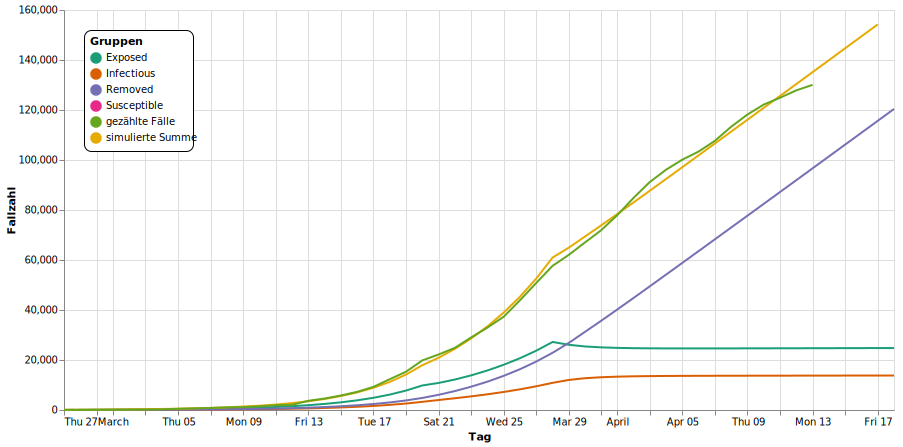

In [8]:
def save_and_display(chart, filename):
    chart.save(os.path.join("charts", filename + ".svg"))
    chart.save(os.path.join("charts", filename + ".png"))
    chart.save(os.path.join("charts", filename + ".html"))
    with open(os.path.join("charts", filename + ".svg"), 'r') as f:
        display(SVG(f.read()))

save_and_display(chart, "fit-quality")

Im Diagramm ist leicht zu sehen, dass das Modell den echten Zahlen mit geringen Abweichungen folgt.

Auf dieser Basis kann man nun eine Prognose für die nächsten 800 Tage berechnen:

In [9]:
def prediction(prediction_days=365, max_val=bev_de, r3=r2, r4=r2,
               it1 = dt.datetime(year=2020, month=3, day=20),
               it2 = dt.datetime(year=2020, month=3, day=28),
               it3 = dt.datetime(year=2020, month=4, day=20),
               it4 = dt.datetime(year=2020, month=4, day=20)):
    cases = np.array(data["Fallzahl"])
    times = np.arange(0., len(cases), 1.0)
    model = SEIR(p0=(bev_de-data["Fallzahl"][0], 0, data["Fallzahl"][0], 0),
                 intervention_times=[(it1-data["Tag"][0]).days, 
                                     (it2-data["Tag"][0]).days, 
                                     (it3-data["Tag"][0]).days, 
                                     (it4-data["Tag"][0]).days],
                 t_vals=times)
    times = np.arange(0., len(cases)+prediction_days, 1.0)
    seir_predictions = model.getSEIR(times, [r0, r1, r2, r3, r4], e0)
    sum_predictions = np.sum(seir_predictions[:, 1:], axis=1)
    dates = [data["Tag"][0] + dt.timedelta(days=i) for i in times]
    seir_data = pd.DataFrame(np.concatenate([
        np.concatenate([np.stack([dates, clip_values(seir_predictions[:, i], max_val), [t]*len(times)], axis=1)
                        for i, t in enumerate(["Susceptible", "Exposed", "Infectious", "Removed"])]),
        np.stack([dates, clip_values(sum_predictions, max_val), ["simulierte Summe"]*len(times)], axis=1)]),
        columns=("Tag", "Fallzahl", "Typ")
    )
    data["Typ"] = "gezählte Fälle"
    return seir_data.append(data, ignore_index=True)

chart = plot(prediction(prediction_days=800), legendY=50, height=300)
chart

alt.LayerChart(...)

In [10]:
save_and_display(chart, "800_days")

Die flache Kurve zeigt, dass es dank der aktuellen Einschränkungen nur wenige gleichzeitige Infektionen geben wird. Das Gesundheitssystem wird mit einem so flachen Peak fertig werden.

Spektakulärer wird die Kurve, wenn die Einschränkungen am 20. April enden würden, was $R_{0}$ auf den Wert vor dem 20. März erhöht:

In [19]:
chart = plot(prediction(prediction_days=100, r3=r0, r4=r0), legendY=50, height=225)
chart

alt.LayerChart(...)

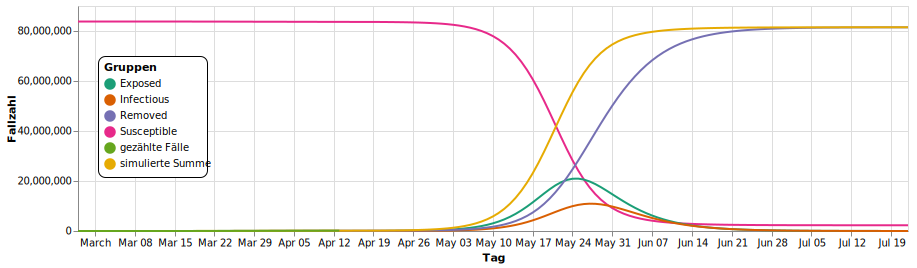

In [20]:
save_and_display(chart, "second_peak")

Schränkt man die Werte noch etwas ein, wird der enorme Peak sichtbar:

In [13]:
chart = plot(prediction(prediction_days=80, max_val=23000000, r3=r0, r4=r0))
chart

alt.LayerChart(...)

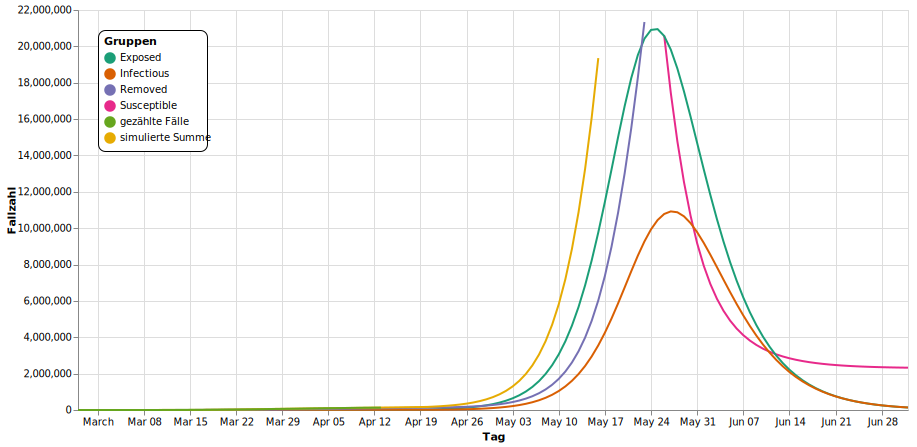

In [14]:
save_and_display(chart, "second_peak_detail")

Nun zu ein paar Rechenmodellen zum Herumspielen: `it3` und `it4` sind zwei Tage, an denen Maßnahmen gelockert werden. Wir haben mal den 1. Januar 2021 voreingestellt, ab dem wieder nur Ausgangsbeschränkungen gelten. Das heißt `r3=r1`, da sie Reproduktionszahl $R_{0}$ wieder auf den Wert vor der Kontaktsperre klettert, sobald diese aufgehoben wird. Da die Ausbreitung dann durch die Ausgangsbeschränkungen weiter gebremst bleibt, ergibt sich ein zweiter Ausbruch, der aber nicht so steil ansteigt, wie ohne Einschränkungen.

Am 20. Februar 2021 (`it4`) werden in unserer Vorereinstellung auch die Ausgangsbeschränkungen aufgehoben. $R_{0}$ steigt daher wieder auf den Wert vor allen Maßnahmen, also ist `r4=r0`.

Zusätzlich können Sie noch mit `prediction_days` einstellen, wie weit die Simulation in die Zukunft rechnet. `max_val` blendet zu hohe Werte im Diagramm aus, damit die y-Achse keinen zu großen Werteberech abbilden muss und man kleinere Kurven besser erkennt.

Spielen Sie ruhig mit den Werten hinter den Kommentaren herum und erstellen Sie eigene Szenarien für die Lockerung der Einschränkungen:

In [15]:
# Tag der Aufhebung der Kontaktsperre
it3 = dt.datetime(year=2021, month=1, day=1)
# Erwartete Reproduktionszahl nach Aufhebung der Kontaktsperre
r3 = r1

# Tag der Aufhebung der Ausgangsbeschränkungen
it4 = dt.datetime(year=2021, month=2, day=20)
# Erwartete Reproduktionszahl nach Aufhebung der Kontaktsperre
r4 = r0

# Zahl der Tage, die die Simulation in die Zukunft berechnet
prediction_days=500
# Höchster Wert im Diagramm (damit die y-Achse die interessanten Werte nicht zu sehr staucht)
max_val=12000000

chart = plot(prediction(prediction_days=prediction_days, max_val=max_val, r3=r3, r4=r4, it3 = it3, it4 = it4))
chart

alt.LayerChart(...)

In [16]:
save_and_display(chart, "loose-restrictions")

Für eine interessante Variante der Simulation stellen Sie $R_{0}$ einfach mal auf Werte ein, die nicht von `curve_fit()` berechnet wurden. Beispielsweise sorgen nach den Interventionstagen Werte für $R_{0}$, die kleiner als 1 sind dafür, dass der Peak an diesem tag vorbei ist. Für sehr kleine $R_{0}$ würde beispielsweise ein genaues Tracking und Isolieren der Infizierten sorgen. Das folgende Diagramm ist wegen der erfundenen Werte aber rein hypothetisch:

In [17]:
# Tag der Aufhebung der Kontaktsperre
it3 = dt.datetime(year=2020, month=5, day=1)
# Erwartete Reproduktionszahl nach Aufhebung der Kontaktsperre
r3 = 0.99

# Tag der Aufhebung der Ausgangsbeschränkungen
it4 = dt.datetime(year=2020, month=7, day=1)
# Erwartete Reproduktionszahl nach Aufhebung der Kontaktsperre
r4 = 0.75

# Zahl der Tage, die die Simulation in die Zukunft berechnet
prediction_days=150
# Höchster Wert im Diagramm (damit die y-Achse die interessanten Werte nicht zu sehr staucht)
max_val=800000

chart = plot(prediction(prediction_days=prediction_days, max_val=max_val, r3=r3, r4=r4, it3 = it3, it4 = it4))
chart

alt.LayerChart(...)

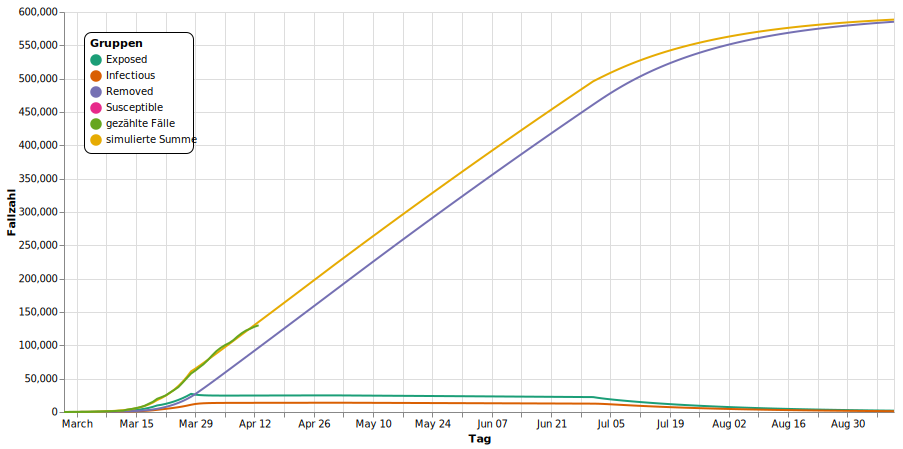

In [18]:
save_and_display(chart, "dreamed-infection-rates")